In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_pickle('orders_extended.pickle')

In [3]:
df = df.drop(['replaced_items_x','cancelled_items_x','replaced_items_y','cancelled_items_y'], axis = 1)

In [5]:
df.shape

(334245, 28)

Агрегируем все данные по месяцам: 

* выручка( как сумма всех платежей за заказы и доставки)

**Схлопываем заказы с несколькоми store_id в один**

In [ ]:
dupl_orders = df[df['order_id'].duplicated(keep = False)]

In [193]:
df = df[~(df['order_id'].duplicated(keep = False))]

In [ ]:
duplicated_orders['store_id'] = dupl_orders.groupby('order_id')['store_id'].apply(lambda x: list(x)).to_frame()
duplicated_orders[['item_total','total_cost']] = dupl_orders.groupby('order_id')[['item_total','total_cost']].sum()
duplicated_orders[['total_weight','total_quantity']] = dupl_orders.groupby('order_id')[['total_weight','total_quantity']].sum()
duplicated_orders['state'] = 'shipped'
duplicated_orders['promo_total'] = dupl_orders.groupby('order_id')['promo_total'].sum()
duplicated_orders[['replaced_items','cancelled_items']] = dupl_orders.groupby('order_id')[['replaced_items','cancelled_items']].sum()
duplicated_orders['moscow_district'] = dupl_orders.groupby('order_id')['moscow_district'].unique()

## Месячные показатели

In [ ]:
df.head(1)

In [ ]:
grouper = pd.Grouper(key = 'shipped_at', freq = '1M')

In [ ]:
month = df.groupby(pd.Grouper( key = 'shipped_at', freq = '1M'))[['total_cost','item_total','total_quantity','total_weight',
                                                        'replaced_items','cancelled_items']].sum()
month['earnings'] = month['total_cost'] + month['item_total']
month['unique_users'] = df.groupby(grouper)['user_id'].nunique()
month['meanOrderPerdistrict'] = df.groupby(grouper)['moscow_district'].apply(lambda x: x.value_counts().mean())
month['orders'] = df.groupby(grouper)['order_id'].nunique()

In [ ]:
df.groupby(grouper)['moscow_district'].apply(lambda x: x.value_counts().mean())

In [ ]:
month

In [ ]:
from sklearn.preprocessing import scale

In [ ]:
pd.DataFrame(scale(month[['earnings','orders','unique_users','total_quantity']]), columns = ['выручка','заказы','клиенты','единицы товара'], index= month.index).plot()

plt.title('Общая динамика основных показателей')
plt.savefig('dynamics.png')

In [ ]:
month['unique_users'].plot()


In [ ]:
month['orders'].plot.bar()

In [ ]:
df.head(6)

**Чуть более общие статистики, в разрезе  заказов**

In [ ]:
print( 'Средняя выручка с одного заказа: ' + str((df['total_cost'] + df['item_total']).mean()))
print('Среднее число единиц товара ' + str(df['total_quantity'].mean()))
print('Средний вес заказа ' + str(df['total_weight'].mean()/1000) +' '+'кг')

**Среднее количество заказов на район в целом в месяц ( в разрезе одного месяца)**

In [ ]:
pd.set_option('display.max_rows', None)
x.groupby('level_1')['moscow_district'].mean().to_frame().sort_values(by= 'moscow_district',ascending = False).mean()

In [ ]:
month

**Статистика по районам**

In [4]:
df['earnings'] = df['total_cost'] + df['item_total']

In [147]:
moscow_orders = df.dropna(subset = ['moscow_district'])

In [149]:
district_stat = pd.concat([
    moscow_orders['moscow_district'].value_counts().to_frame('n_orders'),
    moscow_orders.groupby('moscow_district')['item_total'].mean().to_frame('mean_check')
], axis=1)


In [150]:
user_district_orders = moscow_orders.groupby(['user_id', 'moscow_district'])['item_total'].mean().to_frame('mean_check').reset_index()
user_district_orders.head()

,user_id,moscow_district,mean_check
0,31,Даниловский,6694.000000
1,31,Замоскворечье,12266.404255
2,31,Северное Медведково,20470.000000
3,31,Хамовники,9543.000000
4,45,Пресненский,2173.846154


**Методика расчета**

Проблема: в выборке есть тестовые заказы, которые могут вносить шум в статистику. Например, в районе Ярославский 400 заказов из 1750 сделаны на адрес, который кажется тестовым. Таким образом,почти 25% заказов в этом районе являются тестовыми и зашумляют выборку. Так что предварительно посчитаем средний чек по отдельным людям, а после для каждого района посчитаем среднее значение средних чеков отдельных людей. Это позволит решить еще одну проблему, когда один человек, сделавший много дешевых заказов за счет их количества перевесит богатого человека, сделавшего один, но дорогой заказ. В новом способе и богатый, и обычный клиент будут весить одинаково за счет предварительной агрегации.

In [152]:
agg_district_stat = pd.concat([
    user_district_orders['moscow_district'].value_counts().to_frame('n_users'),
    user_district_orders.groupby('moscow_district')['mean_check'].mean()
], axis=1)

agg_district_stat.sort_values('mean_check', ascending=False).head(20)

,n_users,mean_check
Куркино,235,5472.600114
Арбат,668,5297.296353
Левобережный,721,5253.514277
Тверской,2352,5126.695061
Замоскворечье,1296,5077.929811
Останкинский,823,5068.105759
Пресненский,2573,5033.824957
Хамовники,1873,5022.218058
Солнцево,23,5014.086957
Сокол,689,5012.959577


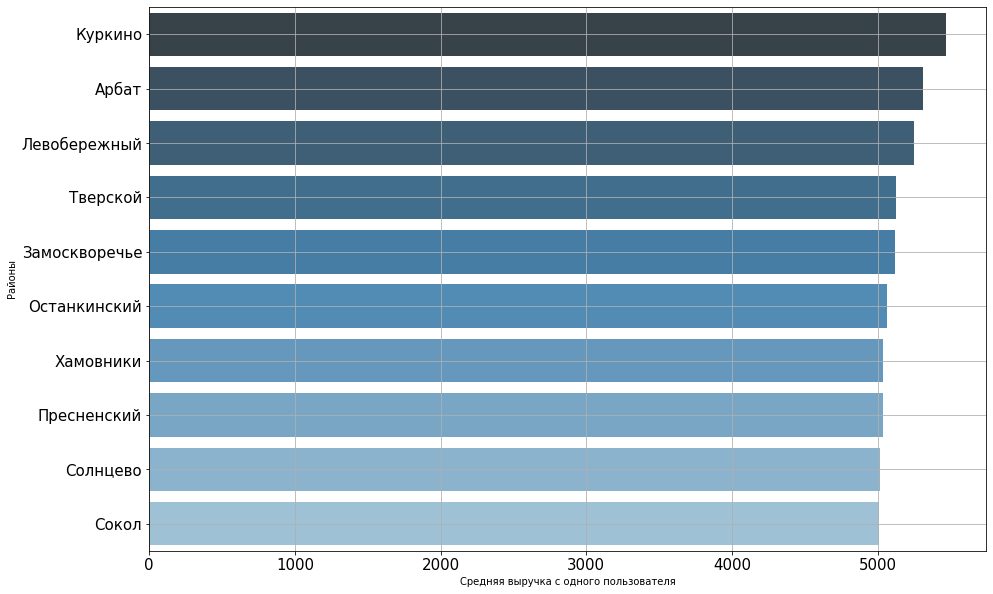

In [163]:
plt.figure(figsize=(15, 10))
b = sns.barplot(x = agg_district_stat.sort_values('mean_check', ascending = False).head(10)['mean_check'], 
            y = agg_district_stat.sort_values('mean_check', ascending = False).head(10).index,palette=("Blues_d"))
b.set_ylabel("Районы",fontsize=10)
b.set_xlabel('Средняя выручка с одного пользователя')
b.tick_params(labelsize=15)
plt.grid()
plt.savefig('rich_dist.png')

**Вывод по топу: самые дорогие заказы делают либо в районах, близких к центру Москвы, либо в районах за МКАДОМ (Куркино, Солнцево)**

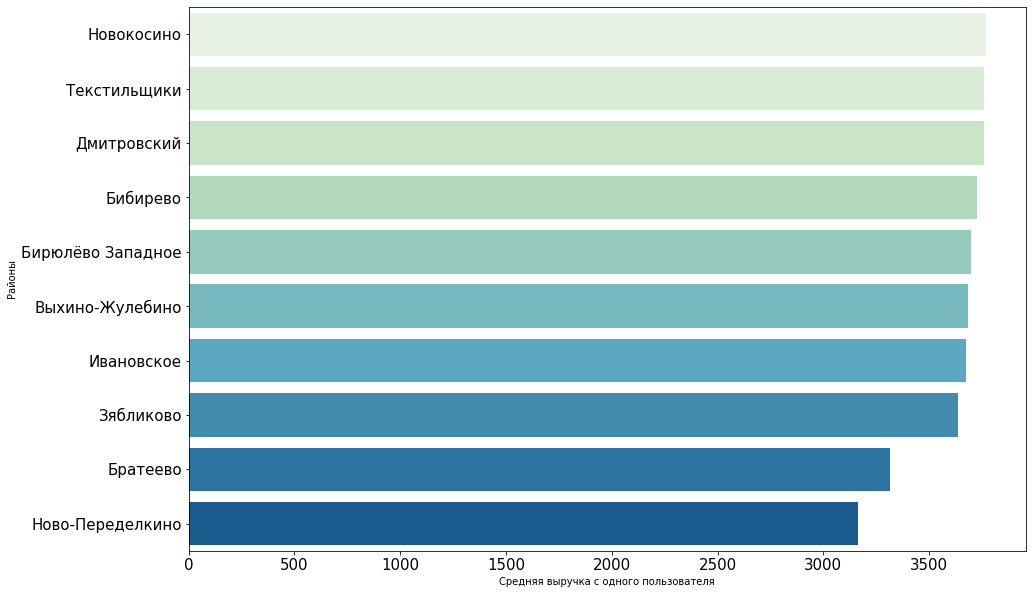

In [153]:
plt.figure(figsize=(15, 10))
b = sns.barplot(x = agg_district_stat.sort_values('mean_check', ascending = False).tail(10)['mean_check'], 
            y = agg_district_stat.sort_values('mean_check', ascending = False).tail(10).index, palette=("GnBu"))
b.set_ylabel("Районы",fontsize=10)
b.set_xlabel('Средняя выручка с одного пользователя')
b.tick_params(labelsize=15)
plt.savefig('poor_dist.png', bbox_inches='tight')

**Вывод по tail: спальные районы с недорогой по меркам Москвы недвижимостью, находящиеся очень далеко от центра**

In [ ]:
agg_district_stat.sort_values('mean_check', ascending=False).tail(10)

In [ ]:
df['time_of_day'].value_counts().plot.pie(autopct='%1.1f%%')

In [ ]:
del moscow_orders 
del district_stat
del user_district_orders

In [166]:
agg_district_stat['mean_check'].mean()

4370.089085284187

In [181]:
agg_district_stat.quantile(q = 0.7)

n_users        947.400000
mean_check    4611.826838
Name: 0.7, dtype: float64

In [184]:
agg_district_stat['mean_check'][(agg_district_stat['mean_check']> 4611) ].mean()

4893.932903585954

In [185]:
del df

In [190]:
moscow_orders.groupby(pd.Grouper(key = 'shipped_at', freq = '1D'))['order_id'].nunique().mean()

462.76083188908143

## Клиенты

In [69]:
y = df.groupby('moscow_district')['earnings'].sum()

In [80]:
pd.DataFrame(y).reset_index()

,moscow_district,earnings
0,Академический,20892870.01
1,Алексеевский,15470575.00
2,Алтуфьевский,1782110.00
3,Арбат,14562722.00
4,Аэропорт,19193685.00
...,...,...
108,Южное Тушино,9097901.00
109,Южнопортовый,9940479.00
110,Якиманка,16205551.00
111,Ярославский,8413595.00


In [86]:
moscow_orders

,order_id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id,city,retailer_id,created_at_nohours,lat,lon,starts_at,ends_at,moscow_district,lates,is_late,day_name,time_of_day,replaced_items,cancelled_items,earnings
0,3158715,61138,290.0,290.0,2543,0.0,89906,35,shipped,2018-01-05 10:50:00,2018-01-05 00:07:04,448086,2,75258.0,1.0,1.0,2018-01-05,55.603020,37.717696,2018-01-05 08:00:00,2018-01-05 10:00:00,Орехово-Борисово Южное,50.0,yes,Friday,Утро,NaN,NaN,2833.0
1,3182881,73307,190.0,190.0,6076,0.0,30275,52,shipped,2018-01-06 15:33:54,2018-01-05 02:04:42,450946,10,75860.0,1.0,1.0,2018-01-05,55.835607,37.519755,2018-01-06 15:00:00,2018-01-06 17:00:00,Коптево,-87.0,no,Saturday,Вечер,NaN,4.0,6266.0
2,3146329,75386,290.0,290.0,2617,0.0,93040,24,shipped,2018-01-11 06:40:38,2018-01-05 02:07:35,458911,14,78635.0,1.0,1.0,2018-01-05,55.713900,37.516982,2018-01-11 06:00:00,2018-01-11 08:00:00,Раменки,-80.0,no,Thursday,Утро,NaN,2.0,2907.0
3,3150465,45970,290.0,290.0,3422,0.0,10518,23,shipped,2018-01-06 12:55:22,2018-01-05 02:15:15,448101,21,75403.0,1.0,1.0,2018-01-05,55.788035,37.558217,2018-01-05 09:00:00,2018-01-05 11:00:00,Беговой,115.0,yes,Saturday,Утро,NaN,1.0,3712.0
4,3169087,49089,90.0,90.0,3666,0.0,22740,31,shipped,2018-01-06 16:17:27,2018-01-05 02:48:52,451302,3,75825.0,1.0,1.0,2018-01-05,55.702004,37.761344,2018-01-06 16:00:00,2018-01-06 18:00:00,Кузьминки,-103.0,no,Saturday,Вечер,NaN,10.0,3756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334239,5271730,179748,178.0,219.0,5718,0.0,31050,32,shipped,2019-08-04 21:23:31,2019-08-04 16:18:43,2417610,14,637253.0,1.0,1.0,2019-08-04,55.684514,37.560865,2019-08-04 19:00:00,2019-08-04 21:00:00,Академический,23.0,yes,Sunday,Вечер,NaN,2.0,5896.0
334241,5512004,527223,1.0,1.0,20286,0.0,30260,41,shipped,2019-08-04 20:44:14,2019-08-04 17:19:21,2668522,12,637201.0,1.0,1.0,2019-08-04,55.763438,37.636069,2019-08-04 20:00:00,2019-08-04 22:00:00,Басманный,-76.0,no,Sunday,Вечер,2.0,2.0,20287.0
334242,5512605,681372,98.0,249.0,1343,-399.0,6898,14,shipped,2019-08-04 20:30:52,2019-08-04 17:28:31,2669120,3,637047.0,1.0,1.0,2019-08-04,55.715936,37.731755,2019-08-04 20:00:00,2019-08-04 22:00:00,Текстильщики,-90.0,no,Sunday,Вечер,2.0,NaN,1441.0
334243,5316955,165630,449.0,449.0,2468,0.0,55524,49,shipped,2019-08-04 20:48:24,2019-08-04 17:36:08,2467589,3,637047.0,1.0,1.0,2019-08-04,55.678906,37.717162,2019-08-04 20:00:00,2019-08-04 22:00:00,Печатники,-72.0,no,Sunday,Вечер,NaN,1.0,2917.0


In [123]:
i = list(moscow_orders['order_id'][moscow_orders['earnings'] > 100000])

In [125]:
selected_user_flag = moscow_orders['order_id'].map(lambda x: 'red' if x in i  else 'blue')

In [128]:
del selected_user_flag
del i

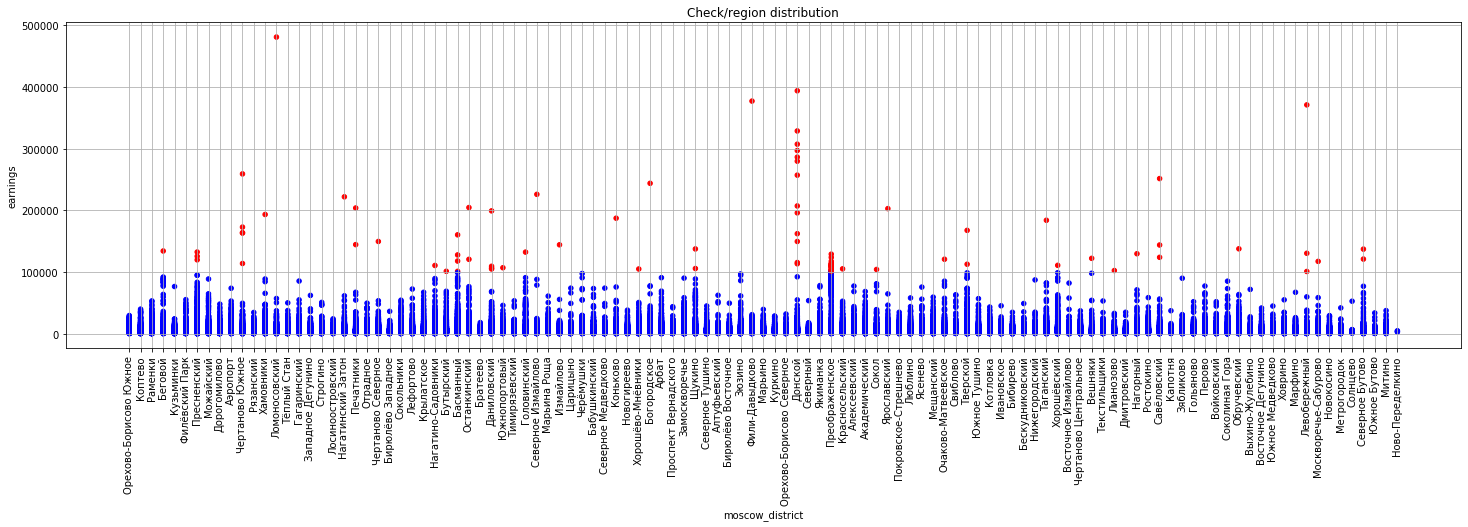

In [126]:
### распределение по регионам 
moscow_orders.plot.scatter(y='earnings', x='moscow_district', figsize=(25,6), c = selected_user_flag)
plt.xticks(moscow_orders['moscow_district'].unique(), rotation='vertical')
plt.grid()

plt.title('Check/region distribution')
plt.savefig('region.png',bbox_inches='tight' )


**Здесь можно увидеть распределение заказов относительно районов, а также красным цветов выделены заказы, которые приносили наибольшую выручку, чтобы понять каким районам это характерно (что в принципе было сделано и ранее)**

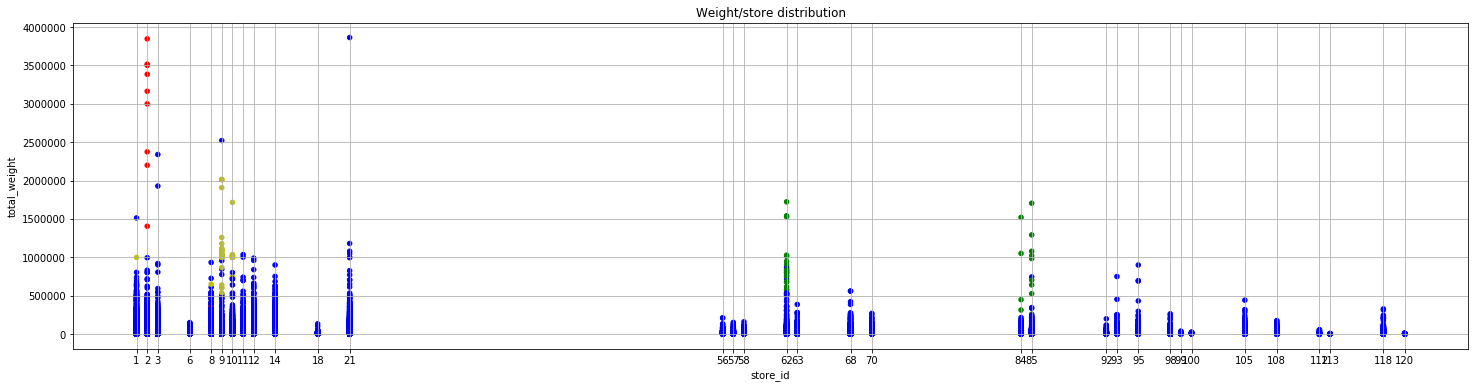

In [129]:
selected_user_flag = (df['user_id'].map(lambda x: x if x in [171371, 165626, 31050] else 'Other')).map({171371:'r', 165626:'g', 31050:'y', 'Other':'b'})

df.plot.scatter(y='total_weight', x='store_id', figsize=(25,6), c=selected_user_flag)
plt.xticks(df['store_id'].unique())
plt.grid()
plt.title('Weight/store distribution')
plt.savefig('weight_store.png')

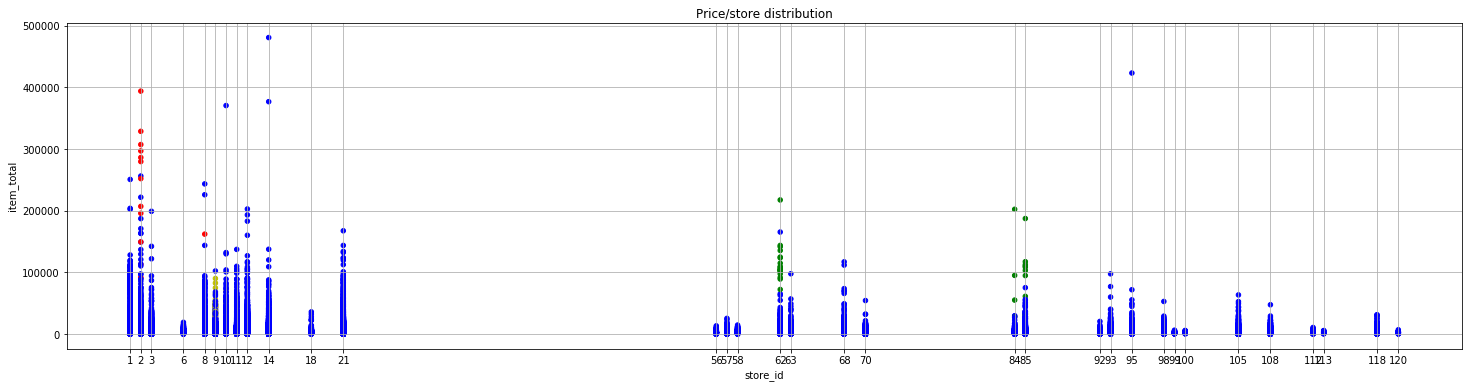

In [130]:
df.plot.scatter(y='item_total', x='store_id', figsize=(25,6), c=selected_user_flag)
plt.xticks(df['store_id'].unique())
plt.grid()
plt.title('Price/store distribution')
plt.savefig('price_store.png')

**На этих графиках распределение по магазину/сумме заказа/весу заказы. В чем суть - увидеть какие магазины поставляют наиболее "огромные" заказы по весу и сумме + цветами выделены три клиенты ( id: 171371, 165626, 31050), которые совершали наиболее "огромные" заказы - примечательно, что например клиент первый делал заказы у магазина №2  и 8, при этом именно ему принадлежат самые большие заказы по сумме и весу - тут можно говорить о некотором уникальном клиенте, и, возможно, на него стоит обратить внимание**

# Общие характеристики бизнеса

order_id - уникальный чек

In [62]:
## общая выручка за период 
print('Общая выручка за период '+str(df['earnings'].sum()/1000000))
print('Средняя выручка за месяц ' + str(df.groupby(pd.Grouper(key = 'shipped_at', freq = '1M'))['earnings'].sum().mean()/1000000) )
print('Количество уникальных заказов за период ' + str(df['order_id'].nunique()) )
print('Среднее количество заказов в месяц ' + str(df.groupby(pd.Grouper(key = 'shipped_at', freq = '1M'))['order_id'].nunique().mean()))
print('Количество уникальных клиентов за весь период ' + str(df['user_id'].nunique()))
print('Количество проданных единиц товаров ' + str(df['total_quantity'].sum()/1000000))


Общая выручка за период 1702.24583022
Средняя выручка за месяц 85.11229151100001
Количество уникальных заказов за период 333087
Среднее количество заказов в месяц 16654.35
Количество уникальных клиентов за весь период 118886
Количество проданных единиц товаров 14.732208


Общая выручка за период 1702245830.22

Средняя выручка за месяц 85112291.511

Количество уникальных заказов за период 333087

Среднее количество заказов в месяц 16654.35

Количество уникальных клиентов за весь период 118886

Среднее количество уникальных клиентов в месяц 11512.8

Количество проданных единиц товаров 14732208

Среднее количество проданных единиц товаров в месяц 736610.4

**Общие статистики, сравнивая 2018 и 2019 год***

In [56]:
## разделим на 2018 и 2019 год
l = [df['earnings'][df['shipped_at'].dt.year == 2018].sum(), df['earnings'][df['shipped_at'].dt.year == 2019].sum(),df['earnings'][df['shipped_at'].dt.year == 2019].sum() - df['earnings'][df['shipped_at'].dt.year == 2018].sum() ]
k = [df['order_id'][df['shipped_at'].dt.year == 2018].nunique(), df['order_id'][df['shipped_at'].dt.year == 2019].nunique(),df['order_id'][df['shipped_at'].dt.year == 2019].nunique() - df['order_id'][df['shipped_at'].dt.year == 2018].nunique() ]
h = [df['earnings'][df['shipped_at'].dt.year == 2018].mean(), df['earnings'][df['shipped_at'].dt.year == 2019].mean(),
     df['earnings'][df['shipped_at'].dt.year == 2019].mean() - df['earnings'][df['shipped_at'].dt.year == 2018].mean()]
r = [df['user_id'][df['shipped_at'].dt.year == 2018].nunique(),df['user_id'][df['shipped_at'].dt.year == 2019].nunique(),
    df['user_id'][df['shipped_at'].dt.year == 2019].nunique() - df['user_id'][df['shipped_at'].dt.year == 2018].nunique()]
x = pd.DataFrame(columns = ['Выручка млн. р',' Кол-во уникальных чеков (тыс)', ' Средний чек', 'Уникальные пользователи'], index =[2018,2019, 'изменение'] )
x.iloc[:,0] = l
x.iloc[:,0] = x.iloc[:,0]/1000000
x.iloc[:,1] = k
x.iloc[:,1] = x.iloc[:,1]/1000
x.iloc[:,2] = h
x.iloc[:,3] = r
x

,Выручка млн. р,Кол-во уникальных чеков (тыс),Средний чек,Уникальные пользователи
2018,753.937840,154.698,4873.610775,60244
2019,948.307991,178.389,5315.955528,72569
изменение,194.370151,23.691,442.344753,12325


In [ ]:
df.groupby(pd.Grouper(key = 'shipped_at', freq = '1M'))['earnings'].sum().index
d.index = [i.strftime("%b %Y") for i in d.index]
d['earnings'] = d['earnings']/1000000

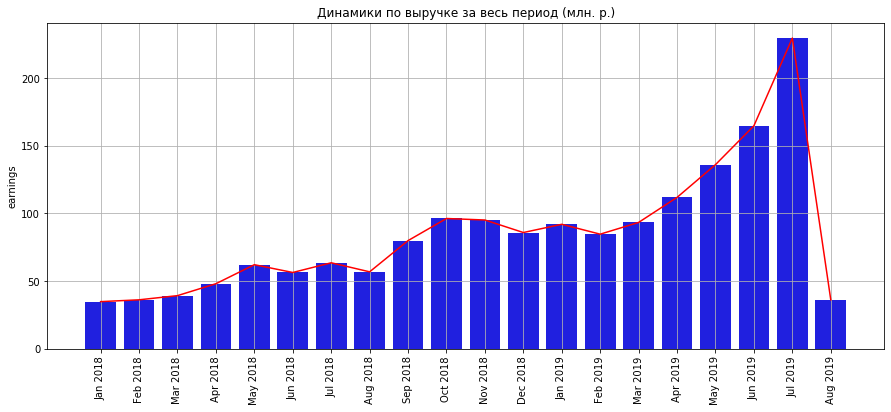

In [53]:
fig = plt.figure(figsize = (15,6))
sns.barplot( x = d.index, y = d['earnings'], color = 'blue')
plt.grid()
plt.xticks(rotation = 90)
plt.plot(d['earnings'], color = 'red')
plt.title('Динамики по выручке за весь период (млн. р.)')
plt.savefig('revenue.png', bbox_inches='tight' )

#  Уникальные клиенты

In [121]:
users = df.groupby(pd.Grouper(key = 'created_at', freq = '1M'))['user_id'].nunique().to_frame('user_count')

In [122]:
users['user_id'] = df.groupby(pd.Grouper(key = 'created_at', freq = '1M'))['user_id'].unique()

In [123]:
users

,user_count,user_id
created_at,,
2018-01-31,5399,"[61138, 73307, 75386, 45970, 49089, 58294, 595..."
2018-02-28,4976,"[57833, 88805, 49406, 45544, 24016, 88815, 519..."
2018-03-31,5629,"[94803, 73378, 38387, 10984, 75730, 65905, 948..."
2018-04-30,7138,"[80389, 22073, 202014, 101361, 101334, 101581,..."
2018-05-31,9279,"[109490, 79645, 72377, 44948, 106792, 109116, ..."
2018-06-30,8192,"[120165, 96373, 107399, 41500, 23468, 112821, ..."
2018-07-31,7982,"[55727, 61547, 66597, 29862, 123271, 65979, 12..."
2018-08-31,8785,"[134394, 92522, 24011, 25083, 134393, 134396, ..."
2018-09-30,11902,"[140022, 64270, 128743, 69439, 1704, 130564, 1..."


## клиенты

* клиенты новые для месяца ( не было в n-1 есть n)

* клиенты вернувшиеся - были хоть раз в приложении появились в месяце

* остающиеся клиенты

* retention??


In [124]:
users_montly = users

In [138]:
users_montly['stayed_previos1'] = pd.Series()
users_montly['stayed_newmonth1'] = pd.Series()
users_montly['new_users1'] = pd.Series()
for i in range(19):
    len1 = len(users_montly['user_id'].iloc[i])
    len2 = len(users_montly['user_id'].iloc[i+1])
    ## Пользователи с прошлого месяца ( осталис)
    x = len(set(users_montly['user_id'].iloc[i]).intersection(users_montly['user_id'].iloc[i+1]))
    ## Процент оставшихся  с прошлого месяца 
    stay = (x/len1)*100
    ## процент оставшихся в новом месяце
    stay2 = (x/len2)*100
    
    ## Новые пользователи
    new = len(set(users_montly['user_id'].iloc[i+1]).difference(users_montly['user_id'].iloc[i]))
    
    new_in = (new/len2)*100
    
    users_montly['stayed_previos1'].iloc[i+1] = stay
    users_montly['stayed_newmonth1'].iloc[i+1] = stay2
    users_montly['new_users1'].iloc[i+1] = new_in
    

C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anastasia\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [142]:
users_montly.head()

,user_count,user_id,stayed_previos1,stayed_newmonth1,new_users1
created_at,,,,,
2018-01-31,5399,"[61138, 73307, 75386, 45970, 49089, 58294, 595...",NaN,NaN,NaN
2018-02-28,4976,"[57833, 88805, 49406, 45544, 24016, 88815, 519...",36.858678,39.991961,60.008039
2018-03-31,5629,"[94803, 73378, 38387, 10984, 75730, 65905, 948...",38.946945,34.428851,65.571149
2018-04-30,7138,"[80389, 22073, 202014, 101361, 101334, 101581,...",38.781311,30.582796,69.417204
2018-05-31,9279,"[109490, 79645, 72377, 44948, 106792, 109116, ...",37.685626,28.990193,71.009807


In [141]:
users_montly[['stayed_newmonth1','new_users1']].mean()

stayed_newmonth1    33.656595
new_users1          66.343405
dtype: float64

**Здесь посчитана средняя доля по месяцам, клиентов которые были в месяце n-1 и остались в n и клиентов, которые появились только в n**

Здесь, возможно, было бы правильнее делать проверку за несколько месяцев: то есть записывать всех клиентов за все месяцы до n и смотреть только уникальных от всех клиентов за несколько прошлых месяцев, но в выборке большинство совершают покупку только раз, поэтому я решила посчитать просто сравнительные доли

# Сегментация клиентов

### Разделяем клиентов на кластеры 

In [5]:
clients_info = df.groupby('user_id')['earnings'].mean().to_frame('mean_check')
clients_info['mean_weight'] = df.groupby('user_id')['total_weight'].mean()
clients_info['mean_quantity'] = df.groupby('user_id')['total_quantity'].mean()
clients_info[['lat','lon']] = df.groupby('user_id')[['lat','lon']].mean()
clients_info['orders'] = df.groupby('user_id')['order_id'].nunique()
clients_info[['min_check','max_check']] = df.groupby('user_id')['earnings'].agg(['min','max'])

In [ ]:
user_diff_days = df.groupby('user_id')['created_at'].apply(lambda x: x.sort_values().diff().mean())

In [6]:
df['promo_delivery'] = (df['cost'] != df['total_cost']).astype('int')

In [7]:
clients_info['promo_delivery'] = df.groupby('user_id')['promo_delivery'].sum()

In [8]:
clients_info['promo_total'] = df.groupby('user_id')['promo_total'].sum()

In [44]:
clients_info.drop(['lat','lon'], axis = 1, inplace = True)

37% - делают больше чем один заказ

то есть большинство - один заказ

In [45]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, random_state= 1)
clusters = km.fit_predict(clients_info)
centers = pd.DataFrame(km.cluster_centers_,columns = clients_info.columns)
clients_info['cluster'] = clusters

In [12]:
354733/1000

354.733

In [32]:
centers.T

,0,1,2
mean_check,3841.670517,8299.820079,20751.200731
mean_weight,15467.389144,77623.281641,354733.191049
mean_quantity,29.210067,84.812170,368.519492
orders,2.750269,3.264081,3.454545
min_check,3247.783869,6950.174456,17075.826411
max_check,4550.002334,10096.081735,25804.149378
promo_delivery,0.832705,0.856959,0.789474
promo_total,-179.907054,-250.593654,-167.425670


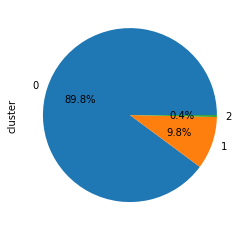

In [63]:
clients_info['cluster'].value_counts(normalize = True).plot.pie(autopct='%1.1f%%')
plt.savefig('cluster_pie.png')

In [45]:
c = clients_info[clients_info['mean_check'] < 50000]

In [46]:
cluster1 = c[c['cluster'] == 0]
cluster2 = c[c['cluster'] == 1]
cluster3 = c[c['cluster'] == 2]

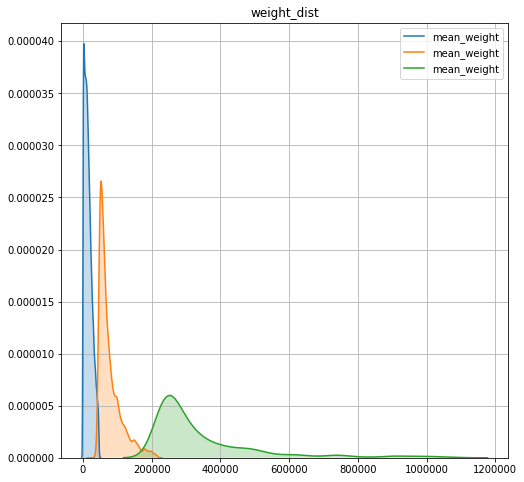

In [50]:
f = plt.figure(figsize = (8,8))
sns.kdeplot(cluster1['mean_weight'],shade=True)
sns.kdeplot(cluster2['mean_weight'], shade=True)
sns.kdeplot(cluster3['mean_weight'], shade=True)
plt.grid()
plt.title('weight_dist')
plt.savefig('weight_dist.png')

In [15]:
clients_info['orders'].value_counts()

1      75732
2      16895
3       7558
4       4412
5       2904
       ...  
146        1
432        1
172        1
112        1
142        1
Name: orders, Length: 130, dtype: int64

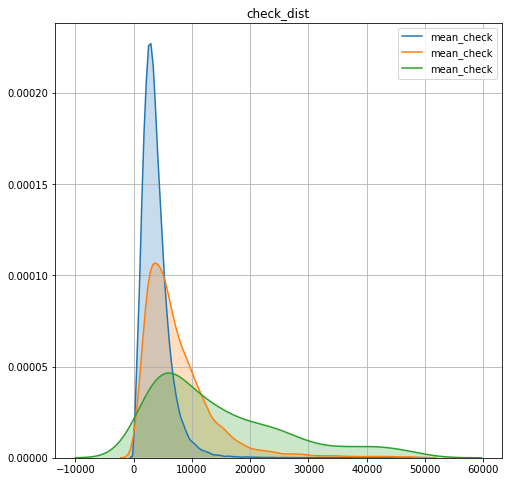

In [51]:
f = plt.figure(figsize = (8,8))
sns.kdeplot(cluster1['mean_check'],shade=True)
sns.kdeplot(cluster2['mean_check'], shade=True)
sns.kdeplot(cluster3['mean_check'], shade=True)
plt.grid()
plt.title('check_dist')
plt.savefig('check_dist.png')

***Как можно увидеть, главным разделяющим признаком стала цена (и вес товаров), где выделяется основной " средний" кластер - туда попадает 90% клиентов***

Интересен последний кластер, который составляет всего 0.4% - несмотря на это, его вклад достаточно сильный - в него входят клиенты, которые заказывают огромные партии товаров, на большие суммы + они делают их с некоторой регулярностью. Скорее всего это какие-то юр. лица, тем не менее это достаточно лояльные клиенты. 

In [78]:
43299/199000


0.21758291457286433

In [77]:
(clients_info['orders'] > 1).sum()

43299